# Analysis of Competing Risks

In classical survival analysis, the focus is on the time until a specific event occurs. If no event is observed during the study period, the time of the event is considered censored. A common assumption is that censoring is non-informative, meaning that censored subjects have a similar prognosis to those who were not censored.

Competing risks arise when each subject can experience an event due to one of $K$ ($K \geq 2$) mutually exclusive causes, termed competing risks. Thus, the occurrence of one event prevents the occurrence of other events. For example, after a bone marrow transplant, a patient might relapse or die from transplant-related causes (transplant-related mortality). In this case, death from transplant-related mortality precludes relapse.

The bone marrow transplant data from [Scrucca et al., Bone Marrow Transplantation (2007)](https://doi.org/10.1038/sj.bmt.1705727) includes data
from 35 patients grouped into two cancer types: Acute Lymphoblastic Leukemia (ALL; coded as 0), and Acute Myeloid Leukemia (AML; coded as 1).

In [1]:
import pandas as pd

from sksurv.datasets import load_bmt

bmt_features, bmt_outcome = load_bmt()

diseases = bmt_features["dis"].cat.rename_categories({"0": "ALL", "1": "AML"})

diseases.value_counts().to_frame()

,count
dis,
AML,18
ALL,17


During the follow-up period, some patients might experience a relapse of the original leukemia or die
while in remission (transplant related death).
The outcome is defined similarly to standard time-to-event data, except that the event indicator specifies the type of event, where 0 always indicates censoring.

In [2]:
status_labels = {
    0: "Censored",
    1: "Transplant related mortality",
    2: "Relapse",
}

risks = pd.DataFrame.from_records(bmt_outcome).assign(label=lambda x: x["status"].replace(status_labels))

risks["label"].value_counts().to_frame()

,count
label,
Relapse,15
Censored,11
Transplant related mortality,9


The table above shows the number of observations for each status.

## Non-parametric Estimator of the Cumulative Incidence Function

If the goal is to estimate the probability of relapse, transplant-related death is a competing risk event. This means that the occurrence of relapse prevents the occurrence of transplant-related death, and vice versa. We aim to estimate curves that illustrate how the likelihood of these events changes over time.

Let's begin by estimating the probability of relapse using the complement of the Kaplan-Meier estimator. With this approach, we treat deaths as censored observations. One minus the Kaplan-Meier estimator provides an estimate of the probability of relapse before time $t$.

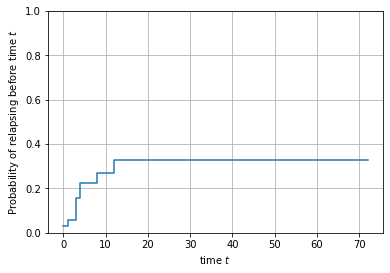

In [3]:
import matplotlib.pyplot as plt

from sksurv.nonparametric import kaplan_meier_estimator

times, km_estimate = kaplan_meier_estimator(bmt_outcome["status"] == 1, bmt_outcome["ftime"])

plt.step(times, 1 - km_estimate, where="post")
plt.xlabel("time $t$")
plt.ylabel("Probability of relapsing before time $t$")
plt.ylim(0, 1)
plt.grid()

However, this approach has a significant drawback: considering death as a censoring event violates the assumption that censoring is non-informative. This is because patients who died from transplant-related mortality have a different prognosis than patients who did not experience any event. Therefore, the estimated probability of relapse is often biased.

The cause-specific **cumulative incidence function (CIF)** addresses this problem by estimating the cause-specific hazard of each event separately. The cumulative incidence function estimates the probability that the event of interest occurs before time $t$, and that it occurs before any of the competing causes of an event. In the bone marrow transplant dataset, the cumulative incidence function of relapse indicates the probability of relapse before time $t$, given that the patient has not died from other causes before time $t$.

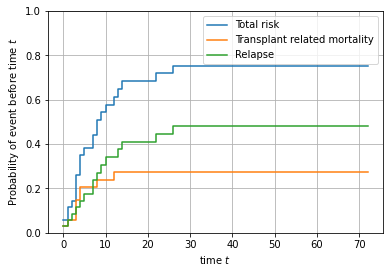

In [4]:
from sksurv.nonparametric import cumulative_incidence_competing_risks

times, cif_estimates = cumulative_incidence_competing_risks(bmt_outcome["status"], bmt_outcome["ftime"])

plt.step(times, cif_estimates[0], where="post", label="Total risk")
for i, cif in enumerate(cif_estimates[1:], start=1):
    plt.step(times, cif, where="post", label=status_labels[i])
plt.legend()
plt.xlabel("time $t$")
plt.ylabel("Probability of event before time $t$")
plt.ylim(0, 1)
plt.grid()

The plot shows the estimated probability of experiencing an event at time $t$ for both the individual risks and for the total risk.

Next, we want to to estimate the cumulative incidence curves for the two cancer types — acute lymphoblastic leukemia (ALL) and acute myeloid leukemia (AML) — to examine how the probability of relapse depends on the original disease diagnosis.

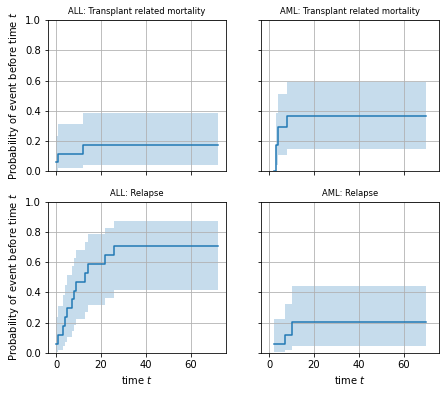

In [5]:
_, axs = plt.subplots(2, 2, figsize=(7, 6), sharex=True, sharey=True)

for j, disease in enumerate(diseases.unique()):
    mask = diseases == disease

    event = bmt_outcome["status"][mask]
    time = bmt_outcome["ftime"][mask]
    times, cif_estimates, conf_int = cumulative_incidence_competing_risks(
        event,
        time,
        conf_type="log-log",
    )

    for i, (cif, ci, ax) in enumerate(zip(cif_estimates[1:], conf_int[1:], axs[:, j]), start=1):
        ax.step(times, cif, where="post")
        ax.fill_between(times, ci[0], ci[1], alpha=0.25, step="post")
        ax.set_title(f"{disease}: {status_labels[i]}", size="small")
        ax.grid()

for ax in axs[-1, :]:
    ax.set_xlabel("time $t$")
for ax in axs[:, 0]:
    ax.set_ylim(0, 1)
    ax.set_ylabel("Probability of event before time $t$")

The left column shows the estimated cumulative incidence curves (solid lines) for patients diagnosed with ALL, while the right column shows the curves for patients diagnosed with AML, along with their 95% pointwise confidence intervals. The plot indicates that the estimated probability of relapse at $t=40$ days is more than three times higher for patients diagnosed with ALL compared to AML.